![title](distributorMap.JPG)

In [1008]:
import pandas as pd
import datetime
import glob
import calendar
import matplotlib.pyplot as plt
import scipy.stats as st

In [1009]:
const_citipower = 'CitiPower'
const_jemena = 'Jemena'
const_powercor = 'Powercor'
const_ausnet = 'AusNet'
const_united = 'United'

In [1010]:
# transform the data extracted from BOM to a format that's easily analysed

def refactor_weather_data(bomDF,year):    
    dateslist = pd.date_range(start=f'1/1/{year}', end=f'31/12/{year}')
    weatherlist  = bomDF['Jan'].tolist()
    if calendar.isleap(year):
        weatherlist = weatherlist + bomDF['Feb'].tolist()[0:29]
    else:
        weatherlist = weatherlist + bomDF['Feb'].tolist()[0:28]          
    weatherlist = weatherlist + bomDF['Mar'].tolist() + bomDF['Apr'].tolist()[0:30] + bomDF['May'].tolist() + bomDF['Jun'].tolist()[0:30] + bomDF['Jul'].tolist() + bomDF['Aug'].tolist() + bomDF['Sep'].tolist()[0:30] + bomDF['Oct'].tolist() + bomDF['Nov'].tolist()[0:30] + bomDF['Dec'].tolist()

    weatherDF = pd.DataFrame({'Date': dateslist, 'Measure': weatherlist})
    return weatherDF


In [1011]:
# Load weather data extracted from BOM
dir = 'BOM/Resources/Weather/_*.csv'
files = glob.glob(dir)
weatherDF = pd.DataFrame()
for f in files:
    filenamelist = f.split("_")
    df = refactor_weather_data(pd.read_csv(f),int(filenamelist[2]))
    df['Distributor'] = filenamelist[1] 
    if filenamelist[3] == '122':
        df['MeasurementType'] = 'MaxTemp'
    elif filenamelist[3] == '123':
        df['MeasurementType'] = 'MinTemp'
    elif filenamelist[3] == '136':
        df['MeasurementType'] = 'Rain Fall'
    elif filenamelist[3] == '193':
        df['MeasurementType'] = 'Solar Exposure'          
    weatherDF = weatherDF.append(df,ignore_index=True)
weatherDF.to_csv('BOM/Resources/Weather/weather.csv')

weatherDF["Measure"] = weatherDF['Measure'].apply(cleanWeatherData)
weatherDF = weatherDF.rename(columns={"Date": "Measure_Date"})
weatherDF.tail()
weatherDF['Measure_Date'] =  pd.to_datetime(weatherDF['Measure_Date'], format="%Y/%m/%d")
weatherDF.head()

,Measure_Date,Measure,Distributor,MeasurementType
0,2015-01-01,26.2,AusNet,MaxTemp
1,2015-01-02,32.5,AusNet,MaxTemp
2,2015-01-03,38.9,AusNet,MaxTemp
3,2015-01-04,25.4,AusNet,MaxTemp
4,2015-01-05,27.3,AusNet,MaxTemp


In [1012]:
# data cleansing of measure column 
def cleanWeatherData(measure):
    para = str(measure)
    res = '0'
    if para == '↓':
        res = '0'
    elif ' days' in para:        
        res = para[:-4]
    else:
        res = para
    return float(res)

In [1013]:
# Load the processed demand data from Electricity Demand Analysis 'Meter data/Demand.csv'

demand_df = pd.read_csv('Meter data/Demand.csv')
demand_df['Measure_Date'] =  pd.to_datetime(demand_df['Measure_Date'], format="%Y/%m/%d")
demand_df = demand_df.loc[demand_df.Measure_Date >= '2014-07-01']
demand_df.reset_index(drop=True, inplace=True)
demand_df.head()    

,Measure_Date,Distributor,Daily_Demand,Business_Demand,Non_Business_Demand
0,2014-07-01,CitiPower,7281406.334,3470018,3811388
1,2014-07-02,CitiPower,6620476.076,3053766,3566710
2,2014-07-03,CitiPower,6962431.361,3177109,3785322
3,2014-07-04,CitiPower,7200371.514,3436765,3763606
4,2014-07-05,CitiPower,6255118.225,0,6255118


In [1014]:
Vicdemand_df = demand_df.groupby(['Measure_Date']).agg({'Daily_Demand': "sum",'Business_Demand': "sum",'Non_Business_Demand': "sum"})
VicdemandDaily_df = pd.DataFrame(Vicdemand_df['Daily_Demand']/1000000)
VicdemandDaily_df = VicdemandDaily_df.rename(columns={"Daily_Demand": "Daily_Demand (GWh)"})

VicdemandBusiness_Demand_df = pd.DataFrame(Vicdemand_df['Business_Demand']/1000000)
VicdemandBusiness_Demand_df = VicdemandBusiness_Demand_df.rename(columns={"Business_Demand": "Business_Demand (GWh)"})

VicNon_Business_Demand_df = pd.DataFrame(Vicdemand_df['Non_Business_Demand']/1000000)
VicNon_Business_Demand_df = VicNon_Business_Demand_df.rename(columns={"Non_Business_Demand": "Non_Business_Demand (GWh)"})


In [1015]:
MaxTempDF = weatherDF.loc[weatherDF.MeasurementType == 'MaxTemp']
MaxTempDF = MaxTempDF.loc[((MaxTempDF.Measure_Date >= '2014-07-01') & (MaxTempDF.Measure_Date < '2019-07-01'))]
MaxTempDF = MaxTempDF.groupby(['Measure_Date']).agg({'Measure': 'mean'})

VicDailyDemand_MaxTemp = VicdemandDaily_df.merge(MaxTempDF, left_index=True, right_index=True)
VicDailyDemand_MaxTemp.dropna(inplace=True)

VicdemandBusiness_Demand_MaxTemp = VicdemandBusiness_Demand_df.merge(MaxTempDF, left_index=True, right_index=True)
VicdemandBusiness_Demand_MaxTemp = VicdemandBusiness_Demand_MaxTemp.loc[VicdemandBusiness_Demand_MaxTemp['Business_Demand (GWh)'] > 0]
VicdemandBusiness_Demand_MaxTemp.dropna(inplace=True)

VicNon_Business_Demand_MaxTemp = VicNon_Business_Demand_df.merge(MaxTempDF, left_index=True, right_index=True)
VicNon_Business_Demand_MaxTemp.dropna(inplace=True)

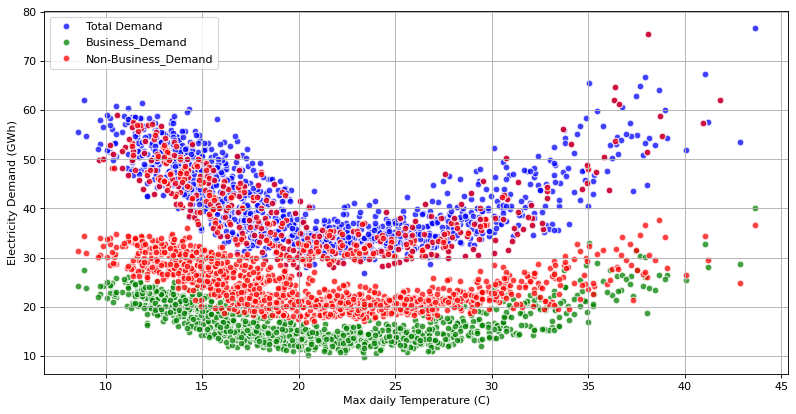

In [1016]:

fig = plt.figure(figsize=(12, 6), dpi=80)
ax1 = fig.add_subplot(111)

ax1.scatter(VicDailyDemand_MaxTemp['Measure'], VicDailyDemand_MaxTemp['Daily_Demand (GWh)'], 
            marker="o", facecolors="blue", edgecolors="white", label='Total Demand',alpha=0.75)
ax1.scatter(VicdemandBusiness_Demand_MaxTemp['Measure'],VicdemandBusiness_Demand_MaxTemp['Business_Demand (GWh)'], 
            marker="o", facecolors="green", edgecolors="white", label='Business_Demand',alpha=0.75)
ax1.scatter(VicNon_Business_Demand_MaxTemp['Measure'],VicNon_Business_Demand_MaxTemp['Non_Business_Demand (GWh)'], 
            marker="o", facecolors="red", edgecolors="white", label='Non-Business_Demand',alpha=0.75)
plt.legend(loc='upper left')
plt.xlabel('Max daily Temperature (C)')
plt.ylabel('Electricity Demand (GWh)')
plt.grid()
plt.show()

In [1017]:
SolarDF = weatherDF.loc[weatherDF.MeasurementType == 'Solar Exposure']
SolarDF = SolarDF.loc[((SolarDF.Measure_Date >= '2014-07-01') & (SolarDF.Measure_Date < '2019-07-01'))]
SolarDF = SolarDF.groupby(['Measure_Date']).agg({'Measure': 'mean'})

VicDailyDemand_SolarDF = VicdemandDaily_df.merge(SolarDF, left_index=True, right_index=True)
VicDailyDemand_SolarDF.dropna(inplace=True)

The correlation between both factors is -0.43


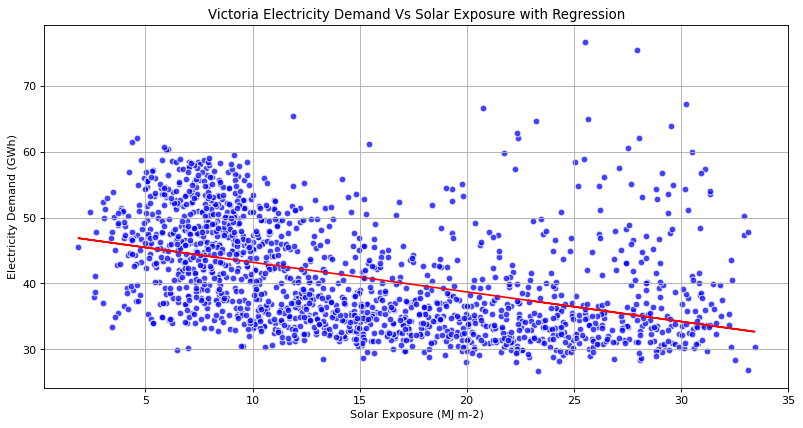

In [1018]:
x_values = VicDailyDemand_SolarDF['Measure']
y_values = VicDailyDemand_SolarDF['Daily_Demand (GWh)']
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept

fig = plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x_values,y_values, marker="o", facecolors="blue", edgecolors="white", alpha=0.75)
plt.plot(x_values,regress_values,"r-")
plt.xlabel("Solar Exposure (MJ m-2)")
plt.ylabel("Electricity Demand (GWh)")
plt.title("Victoria Electricity Demand Vs Solar Exposure with Regression")
plt.grid()
plt.show()

In [1019]:
# seperate three segments to analyse if there is any significance electricity demand between differerent solar expossures

VicDailyDemand_Solar_Low = VicDailyDemand_SolarDF.loc[VicDailyDemand_SolarDF['Measure'] < 10].sample(n = 100) 
VicDailyDemand_Solar_Med = VicDailyDemand_SolarDF.loc[(VicDailyDemand_SolarDF['Measure'] >= 10) & (VicDailyDemand_SolarDF['Measure'] < 20)].sample(n = 100) 
VicDailyDemand_Solar_High = VicDailyDemand_SolarDF.loc[(VicDailyDemand_SolarDF['Measure'] >= 20) & (VicDailyDemand_SolarDF['Measure'] < 30)].sample(n = 100)  

st.f_oneway(VicDailyDemand_Solar_Low['Daily_Demand (GWh)'], VicDailyDemand_Solar_Low['Daily_Demand (GWh)'], VicDailyDemand_Solar_Low['Daily_Demand (GWh)'])

F_onewayResult(statistic=0.0, pvalue=1.0)

In [1020]:
RainDF = weatherDF.loc[weatherDF.MeasurementType == 'Rain Fall']
RainDF = RainDF.loc[((RainDF.Measure_Date >= '2014-07-01') & (RainDF.Measure_Date < '2019-07-01'))]
RainDF = RainDF.groupby(['Measure_Date']).agg({'Measure': 'mean'})

VicDailyDemand_RainDF = VicdemandDaily_df.merge(RainDF, left_index=True, right_index=True)
VicDailyDemand_RainDF.head()

,Daily_Demand (GWh),Measure
Measure_Date,,
2015-01-01,28.756751,0.00
2015-01-02,44.726836,0.00
2015-01-03,54.763326,0.00
2015-01-04,31.517862,5.52
2015-01-05,32.255049,0.08


The correlation between both factors is 0.04


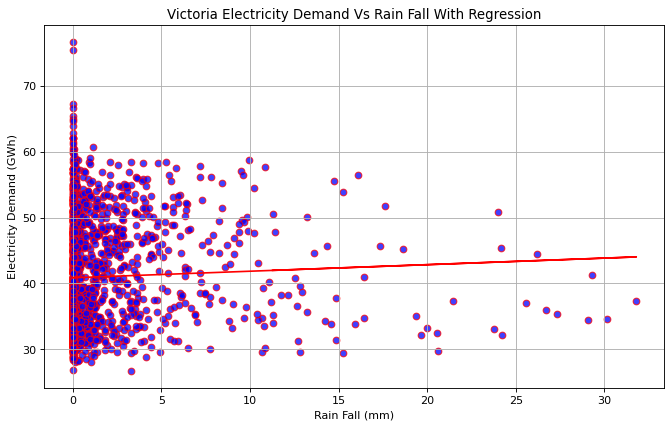

In [1021]:
x_values = VicDailyDemand_RainDF['Measure']
y_values = VicDailyDemand_RainDF['Daily_Demand (GWh)']
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept

fig = plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(x_values,y_values, marker="o", facecolors="blue", edgecolors="red", alpha=0.75)
plt.plot(x_values,regress_values,"r-")
plt.xlabel("Rain Fall (mm)")
plt.ylabel("Electricity Demand (GWh)")
plt.title("Victoria Electricity Demand Vs Rain Fall With Regression")
plt.grid()
plt.show()

In [1022]:
# compare electricity demand for low, med and high rain to see if there is any significance
VicDailyDemand_RainLow = VicDailyDemand_RainDF.loc[VicDailyDemand_RainDF['Measure'] < 10].sample(n = 10)
VicDailyDemand_RainMed = VicDailyDemand_RainDF.loc[(VicDailyDemand_RainDF['Measure'] >= 10) & (VicDailyDemand_RainDF['Measure'] < 20)].sample(n = 10)
VicDailyDemand_RainHigh = VicDailyDemand_RainDF.loc[(VicDailyDemand_RainDF['Measure'] >= 20) & (VicDailyDemand_RainDF['Measure'] < 30)].sample(n = 10)

st.f_oneway(VicDailyDemand_RainLow['Daily_Demand (GWh)'], VicDailyDemand_RainMed['Daily_Demand (GWh)'], VicDailyDemand_RainHigh['Daily_Demand (GWh)'])

F_onewayResult(statistic=0.1830471366733847, pvalue=0.8337536791032001)

POWERCOR distributor covers western victoria subarbs and regions while CITIPOWER is covering the Melbourne City

T Test to analyse CITIPOWER and POWERCOR demand variation with solar exposure to see if significant difference

In [1023]:
# demand distribution for citipower
citiDemandDF = demand_df.loc[demand_df.Distributor == const_citipower]
citiDemandDF = citiDemandDF[["Measure_Date","Daily_Demand"]]
citiDemandDF = citiDemandDF.set_index('Measure_Date', drop = True)
citiDemandDF = pd.DataFrame(citiDemandDF['Daily_Demand']/1000000)
citiDemandDF = citiDemandDF.rename(columns={"Daily_Demand": "Daily_Demand (GWh)"})

# demand distribution for powercor
powcDemandDF = demand_df.loc[demand_df.Distributor == const_powercor]
powcDemandDF = powcDemandDF[["Measure_Date","Daily_Demand"]]
powcDemandDF = powcDemandDF.set_index('Measure_Date', drop = True)
powcDemandDF = pd.DataFrame(powcDemandDF['Daily_Demand']/1000000)
powcDemandDF = powcDemandDF.rename(columns={"Daily_Demand": "Daily_Demand (GWh)"})

# temperature distribution for citip
MaxTempcitiDF = weatherDF.loc[(weatherDF.Distributor == const_citipower) & (weatherDF.MeasurementType == 'MaxTemp')]
MaxTempcitiDF = MaxTempcitiDF.loc[((MaxTempcitiDF.Measure_Date >= '2014-07-01') & (MaxTempcitiDF.Measure_Date < '2019-07-01'))]
MaxTempcitiDF = MaxTempcitiDF[['Measure_Date','Measure']]
MaxTempcitiDF = MaxTempcitiDF.set_index('Measure_Date', drop = True)

# temperature distribution for powcp
MaxTempPowcpDF = weatherDF.loc[(weatherDF.Distributor == const_powercor) & (weatherDF.MeasurementType == 'MaxTemp')]
MaxTempPowcpDF = MaxTempPowcpDF.loc[((MaxTempPowcpDF.Measure_Date >= '2014-07-01') & (MaxTempPowcpDF.Measure_Date < '2019-07-01'))]
MaxTempPowcpDF = MaxTempPowcpDF[['Measure_Date','Measure']]
MaxTempPowcpDF = MaxTempPowcpDF.set_index('Measure_Date', drop = True)

citiDemand_MaxTemp = citiDemandDF.merge(MaxTempcitiDF, left_index=True, right_index=True)
citiDemand_MaxTemp.dropna(inplace=True)

powcpDemand_MaxTemp = powcDemandDF.merge(MaxTempPowcpDF, left_index=True, right_index=True)
powcpDemand_MaxTemp.dropna(inplace=True)


The correlation between both factors for CitiPower for Low temperature is -0.72
The correlation between both factors for Powercor for Low temperature is -0.86
The correlation between both factors for CitiPower for High temperature is 0.62
The correlation between both factors for Powercor for High temperature is 0.82


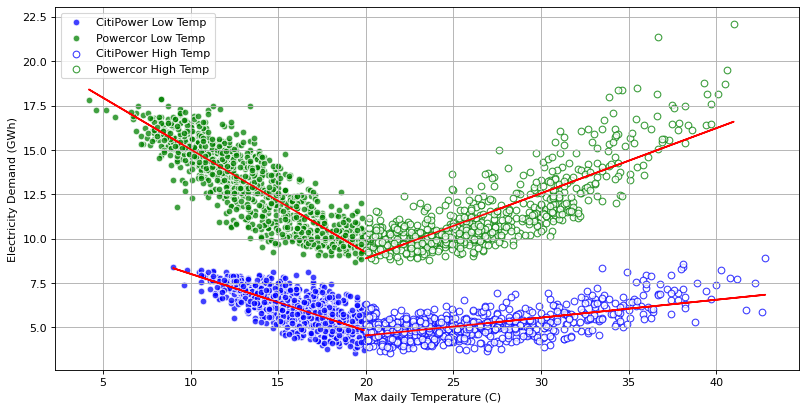

In [1024]:


citiDemand_LowTemp  = citiDemand_MaxTemp.loc[citiDemand_MaxTemp['Measure'] < 20]
powcpDemand_LowTemp = powcpDemand_MaxTemp.loc[powcpDemand_MaxTemp['Measure'] < 20]
citiDemand_HighTemp  = citiDemand_MaxTemp.loc[citiDemand_MaxTemp['Measure'] >= 20]
powcpDemand_HighTemp = powcpDemand_MaxTemp.loc[powcpDemand_MaxTemp['Measure'] >= 20]

x1 = citiDemand_LowTemp['Measure']
y1 = citiDemand_LowTemp['Daily_Demand (GWh)']

x2 = powcpDemand_LowTemp['Measure']
y2 = powcpDemand_LowTemp['Daily_Demand (GWh)']

x3 = citiDemand_HighTemp['Measure']
y3 = citiDemand_HighTemp['Daily_Demand (GWh)']

x4 = powcpDemand_HighTemp['Measure']
y4 = powcpDemand_HighTemp['Daily_Demand (GWh)']

correlation1 = st.pearsonr(x1,y1)
correlation2 = st.pearsonr(x2,y2)
correlation3 = st.pearsonr(x3,y3)
correlation4 = st.pearsonr(x4,y4)

print(f"The correlation between both factors for {const_citipower} for Low temperature is {round(correlation1[0],2)}")
print(f"The correlation between both factors for {const_powercor} for Low temperature is {round(correlation2[0],2)}")
print(f"The correlation between both factors for {const_citipower} for High temperature is {round(correlation3[0],2)}")
print(f"The correlation between both factors for {const_powercor} for High temperature is {round(correlation4[0],2)}")

(slope1, intercept1, rvalue1, pvalue1, stderr1) = st.linregress(x1, y1)
(slope2, intercept2, rvalue2, pvalue2, stderr2) = st.linregress(x2, y2)
(slope3, intercept3, rvalue1, pvalue3, stderr3) = st.linregress(x3, y3)
(slope4, intercept4, rvalue4, pvalue4, stderr4) = st.linregress(x4, y4)


regress_values1 = x1 * slope1 + intercept1
regress_values2 = x2 * slope2 + intercept2
regress_values3 = x3 * slope3 + intercept3
regress_values4 = x4 * slope4 + intercept4

fig = plt.figure(figsize=(12, 6), dpi=80)
ax1 = fig.add_subplot(111)

ax1.scatter(x1, y1, marker="o", facecolors="blue",  edgecolors="white", label=const_citipower + " Low Temp",alpha=0.75)
ax1.scatter(x2, y2, marker="o", facecolors="green", edgecolors="white", label=const_powercor  + " Low Temp",alpha=0.75)
ax1.scatter(x3, y3, marker="o", facecolors="white", edgecolors="blue",  label=const_citipower + " High Temp",alpha=0.75)
ax1.scatter(x4, y4, marker="o", facecolors="white", edgecolors="green", label=const_powercor  + " High Temp",alpha=0.75)
ax1.plot(x1,regress_values1,"r-")
ax1.plot(x2,regress_values2,"r-")
ax1.plot(x3,regress_values3,"r-")
ax1.plot(x4,regress_values4,"r-")

plt.legend(loc='upper left')
plt.xlabel('Max daily Temperature (C)')
plt.ylabel('Electricity Demand (GWh)')
plt.grid()
plt.show()

In [1025]:
# Taking euqal sized samples from each distribution for T-Test
citiDemand_LowTemp = citiDemand_LowTemp.sample(n = 100) 
powcpDemand_LowTemp = powcpDemand_LowTemp.sample(n = 100) 
citiDemand_HighTemp = citiDemand_HighTemp.sample(n = 100) 
powcpDemand_HighTemp = powcpDemand_HighTemp.sample(n = 100) 

In [1026]:
st.ttest_ind(powcpDemand_LowTemp['Daily_Demand (GWh)'], powcpDemand_HighTemp['Daily_Demand (GWh)'], equal_var=False)

Ttest_indResult(statistic=3.963880424337968, pvalue=0.00010332548118721451)

In [1027]:
st.ttest_ind(citiDemand_LowTemp['Daily_Demand (GWh)'], citiDemand_HighTemp['Daily_Demand (GWh)'], equal_var=False)

Ttest_indResult(statistic=7.055501703623393, pvalue=3.240080359662745e-11)